# All-optical control

Here we will see how to do two-photon optogenetics and calcium imaging simultaneously.

In [1]:
import brian2 as b2
from brian2 import np
import cleo
from cleo import opto, imaging

# numpy faster than cython for lightweight example
b2.prefs.codegen.target = 'numpy'
# for reproducibility
rng = np.random.default_rng(92)

cleo.utilities.style_plots_for_docs()

In [2]:
scope = imaging.Scope(
    focus_depth=100 * b2.um,
    img_width=500 * b2.um,
    sensor=imaging.gcamp6f(),
)

ng = b2.NeuronGroup(
    500,
    """
    dv/dt = (
        -(v - E_L)
        + Delta_T*exp((v-theta)/Delta_T)
        + Rm*Iopto
    ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
    Iopto : amp
    """,
    threshold="v > -10*mV",
    reset="v=E_L",
    namespace={
        "tau_m": 20 * b2.ms,
        "Rm": 500 * b2.Mohm,
        "theta": -50 * b2.mV,
        "Delta_T": 2 * b2.mV,
        "E_L": -70 * b2.mV,
        "sigma": 5 * b2.mV,
        "I_bg": 60 * b2.pamp,
    },
)
cleo.coords.assign_coords_rand_rect_prism(ng, [-0.2, 0.2], [-0.2, 0.2], [0, 0.4])
sim = cleo.CLSimulator(b2.Network(ng))

By default a scope selects neurons based on focus depth and assigns them a signal-to-noise ratio (SNR) based on soma size.
(Larger cells' SNR decays more slowly with distance from the focal plane.)
`focus_depth` and `soma_radius` are taken from scope parameters but can be overridden on injection.

In [3]:
sim.inject(scope, ng)  # uses scope's parameters
# optional overrides
sim.inject(scope, ng, focus_depth=200 * b2.um, soma_radius=7 * b2.um)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/imaging/scope.py:37: RuntimeWarning: invalid value encountered in sqrt
  r_soma_visible = np.sqrt(soma_radius**2 - perp_distances**2)
 [py.warnings]
WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/imaging/scope.py:44: RuntimeWarning: divide by zero encountered in divide
  noise_focus_factor /= np.sqrt(relative_num_pixels)
 [py.warnings]


CLSimulator(io_processor=None, devices={Scope(sim=..., name='Scope', save_history=True, sensor=GECI(sim=None, name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            dCaB_active/dt = beta : mmolar (clock-driven)\n            lam = 1/t_off + 1/t_on : 1/second\n            kap = 1/t_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                ca_amp * (lam - kap) * Ca   # M/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * CaB_active    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF = exc_factor * rho_rel * dFF_max / (1 + (K_d / CaB_active) ** n_H) : 1\n            rho_rel : 1\n        ', sigma_noise=3.748181818181818, dFF_1AP=9.775500000000001, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T 

While Cleo adjusts SNR according to distance from the focal plane automatically, other SNR adjustments can be made manually by calling {meth}`~cleo.imaging.Scope.target_neurons_in_plane` to reflect factors such as heterogeneous soma sizes or indicator expression or reduced SNR with depth.

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

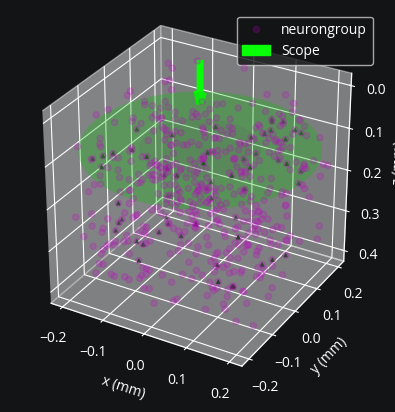

In [4]:
i_targets, noise_focus_factor, focus_coords = scope.target_neurons_in_plane(ng, focus_depth=300 * b2.um)
# scale noise std σ randomly to simulate biological variability
std_noise = scope.sensor.sigma_noise * noise_focus_factor * rng.normal(1, .2, len(i_targets))
sim.inject(scope, ng, focus_depth=None, i_targets=i_targets, sigma_noise = std_noise)

cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

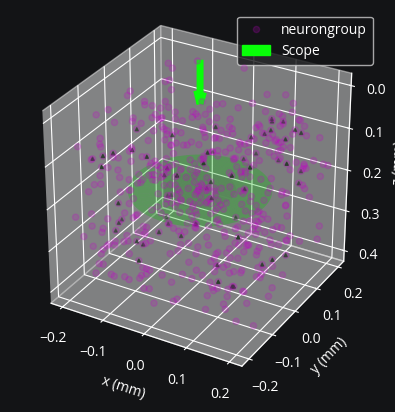

In [5]:
from cleo.imaging import Scope
scope.focus_depth = 200 * b2.um
scope.img_width = 300 * b2.um
scope.direction = [0, 0, 1]
cleo.viz.plot(ng, colors=['#c500cc'], sim=sim)


When `focus_depth` is set to `None`, corresponding to [sculpted holographic imaging](https://www.sciencedirect.com/science/article/pii/S0959438817301940), the scope will select all neurons in the volume, or the user can specify a list of neurons to select via `i_targets` on injection.

After all targets are specified, the sensor protein must also be injected:

In [6]:
scope.inject_sensor_for_targets()

## Opsin
Not sure how to scale 2P action spectrum in relation to the 1P spectrum, so we'll make it up:

In [7]:
from cleo import light
opsin = opto.vfchrimson_4s()
opsin.spectrum.append((1060, .01))

In [8]:
sim.inject(opsin, ng)

CLSimulator(io_processor=None, devices={GECI(sim=..., name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            dCaB_active/dt = beta : mmolar (clock-driven)\n            lam = 1/t_off + 1/t_on : 1/second\n            kap = 1/t_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                ca_amp * (lam - kap) * Ca   # M/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * CaB_active    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF = exc_factor * rho_rel * dFF_max / (1 + (K_d / CaB_active) ** n_H) : 1\n            rho_rel : 1\n        ', sigma_noise=3.748181818181818, dFF_1AP=9.775500000000001, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', model='\n            dCa/dt 

Now, to target these neurons with 2P laser power, we use {meth}`~cleo.light.tp_light_from_scope` to create a `Light` object with a 2P laser {class}`~cleo.light.GaussianEllipsoid` light profile centered on each of the scope's targets:

In [10]:
laser = light.tp_light_from_scope(scope)
sim.inject(laser, ng)

CLSimulator(io_processor=None, devices={GECI(sim=..., name='gcamp6f', save_history=True, model='\n            dCa/dt = -gamma * (Ca - Ca_rest) / (1 + kappa_S + kappa_B) : mmolar (clock-driven)\n            kappa_B = B_T * K_d / (Ca + K_d)**2 : 1\n\n            dCaB_active/dt = beta : mmolar (clock-driven)\n            lam = 1/t_off + 1/t_on : 1/second\n            kap = 1/t_off : 1/second\n            dbeta/dt = (                    # should be M/s/s\n                ca_amp * (lam - kap) * Ca   # M/s\n                - (kap + lam) * beta        # M/s/s\n                - kap * lam * CaB_active    # M/s/s\n            ) : mmolar/second (clock-driven)\n            \nexc_factor = 1 : 1\n\n            dFF = exc_factor * rho_rel * dFF_max / (1 + (K_d / CaB_active) ** n_H) : 1\n            rho_rel : 1\n        ', sigma_noise=3.748181818181818, dFF_1AP=9.775500000000001, location='cytoplasm', cal_model=DynamicCalcium(on_pre='Ca += dCa_T / (1 + kappa_S + kappa_B)', model='\n            dCa/dt 

(<Figure size 400x400 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

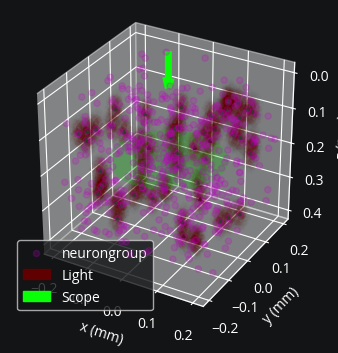

In [158]:
laser.light_model.sigma_axial = 18*b2.um
laser.light_model.sigma_lateral = 8*b2.um
laser.wavelength = 1000*b2.nmeter
cleo.viz.plot(ng, colors=['#c500cc'], sim=sim, figsize=(4,4))